In [83]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import skimage.transform as st

from segmentation import PersonSegmentationExtractor

In [476]:
fg_path = '/Users/gauranshurathee/Desktop/shadow_positioning/temp/fg.png'
# bg_path = '/Users/gauranshurathee/Desktop/shadow_positioning/test_data/png_raw_images_dataset/hard_shadow/BG_20_FG_00.png'
bg_path = '/Users/gauranshurathee/Desktop/shadow_positioning/temp/bg.png'
mask_path = '/Users/gauranshurathee/Desktop/shadow_positioning/temp/mask.png'

bg = cv2.imread(bg_path)

fg = cv2.imread(fg_path)
comp_mask = cv2.imread(mask_path, 0)
bg.shape, fg.shape

((4032, 2268, 3), (3376, 6000, 3))

In [554]:
def constraint_image(image, max_size=2400):

    h, w = image.shape[:2]
    
    scaling_factor = max_size / [w, h][h>w]
    
    nw = int(w * scaling_factor)
    nh = int(h * scaling_factor)
    
    # Resize the image
    resized_img = cv2.resize(image, (nw, nh))
    return resized_img

bg = constraint_image(bg, 2400)
comp_mask = constraint_image(comp_mask, 2400)

In [555]:
cv2.imwrite('bg.png', bg)

True

In [556]:
class Harmonize:
    def __init__(self):
        self.mask_extractor = PersonSegmentationExtractor()

    def harmonization(self, image, mask):
        harmonized = image.copy()
        harmonized[:,:,0] //= 10

        mask_3 = np.stack([mask]*3, axis=-1)
        targeted_image = image * (1-mask_3) + harmonized * mask_3
        return targeted_image

    def positioning_rule(self, fg_mask, bg_mask):
        fg_bbox = cv2.boundingRect(fg_mask)
        bg_bbox = cv2.boundingRect(bg_mask.astype('uint8'))

        scaling_factor = fg_bbox[3] / bg_bbox[3]
        est_w = bg_bbox[2] * scaling_factor
        if est_w > fg_bbox[0]:
            scaling_factor = fg_bbox[2] // bg_bbox[2]
        est_w = bg_bbox[2] * scaling_factor
        
        x = int(fg_bbox[0] - est_w)
        y = fg_bbox[1]
        w = int(est_w)
        h = int(bg_bbox[3] * scaling_factor)
        self.pos = (x, y, w, h)

        print(bg_bbox[2], scaling_factor)
        print(self.pos, fg_bbox, scaling_factor)
        # self.pos = (0, 0, bg_bbox[2], bg_bbox[3])

        return self.pos

    def step1(self, fg, bg, mask):
        bbox = {}
        blended = fg.copy()
        comp_mask = np.zeros_like(fg)[:,:,0]

        x, y, w, h = cv2.boundingRect(mask)
        bbox['og'] = (x,y,w,h)

        roi = bg[y:y+h, x:x+w]
        roi_mask = mask[y:y+h, x:x+w]

        x, y, w, h = self.pos
        bbox['tf'] = (x,y,w,h)
        resized_roi = cv2.resize(roi, (w, h))
        resized_mask = st.resize(roi_mask, (h, w), order=0, anti_aliasing=False)

        harmonized = self.harmonization(resized_roi, resized_mask)

        blended[y:y+h, x:x+w][resized_mask==1] = harmonized[resized_mask==1]
        comp_mask[y:y+h, x:x+w] = resized_mask

        return blended, comp_mask, bbox
    
    def step2(self, fg, bg, fg_mask, comp_mask):
        blended = bg.copy()

        x, y, w, h = cv2.boundingRect(fg_mask)
        roi = fg[y:y+h, x:x+w]
        roi_mask = fg_mask[y:y+h, x:x+w]

        x, y, w, h = cv2.boundingRect(comp_mask)
        resized_roi = cv2.resize(roi, (w, h))
        resized_mask = st.resize(roi_mask, (h, w), order=0, anti_aliasing=False)

        harmonized = self.harmonization(resized_roi, resized_mask)
        
        blended[y:y+h, x:x+w][resized_mask==1] = harmonized[resized_mask==1]
        return blended
    
    def step3(self, image, mask, bg, comp_mask, bbox):
        
        blended = bg.copy()
        result_mask = comp_mask.copy()
        
        x, y, w, h = bbox['tf']
        roi = image[y:y+h, x:x+w]
        roi_mask = mask[y:y+h, x:x+w]

        x, y, w, h = bbox['og']
        resized_roi = cv2.resize(roi, (w, h), interpolation=cv2.INTER_AREA)
        resized_mask = st.resize(roi_mask, (h, w), order=0, anti_aliasing=False)

        blended[y:y+h, x:x+w][resized_mask==1] = resized_roi[resized_mask==1]
        result_mask[y:y+h, x:x+w] = resized_mask

        harmonized = self.harmonization(blended, result_mask)

        return harmonized, result_mask

    def infer(self, fg, bg, comp_mask):
        # bg could be blended image or og bg

        comp_mask = (comp_mask>128).astype('uint8')

        bg_masks = [
                (mask>0).astype('uint8')
                for mask in 
                self.mask_extractor.get_person_masks(bg)
            ]
        bg_mask = np.maximum.reduce(bg_masks)
        fg_mask = (self.mask_extractor.get_person_masks(fg)[0]>128).astype('uint8')

        self.positioning_rule(fg_mask, bg_mask)
        bg_over_fg_image, bg_over_fg_mask, bbox = self.step1(fg, bg, bg_mask)
        fg_over_bg_image = self.step2(fg, bg, fg_mask, comp_mask)
        result_image, result_mask = self.step3(bg_over_fg_image, bg_over_fg_mask, fg_over_bg_image, comp_mask, bbox)

        return result_image, result_mask

In [557]:
harmonizer = Harmonize()
a=harmonizer.infer(fg, bg, comp_mask)

Initialized Person Segmentation Extraction Models...

0: 640x384 1 person, 1 motorcycle, 71.7ms
Speed: 1.6ms preprocess, 71.7ms inference, 0.1ms postprocess per image at shape (1, 3, 640, 384)

0: 1024x1024 1 0, 1990.2ms
Speed: 6.3ms preprocess, 1990.2ms inference, 11.5ms postprocess per image at shape (1, 3, 1024, 1024)

0: 384x640 1 person, 72.3ms
Speed: 1.8ms preprocess, 72.3ms inference, 0.2ms postprocess per image at shape (1, 3, 384, 640)

0: 1024x1024 1 0, 1912.7ms
Speed: 6.3ms preprocess, 1912.7ms inference, 79.7ms postprocess per image at shape (1, 3, 1024, 1024)
362 2.2266791044776117
(1975, 457, 806, 2387) (2782, 457, 678, 2387) 2.2266791044776117


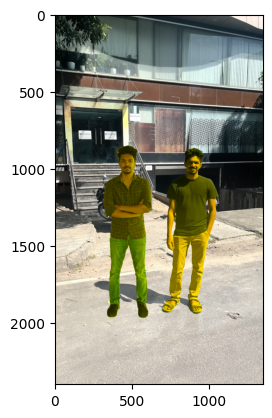

In [559]:
plt.imshow(a[0][:,:,::-1])
# cv2.imwrite('temp/bg_over_fg.png', a[0])

In [560]:
cv2.imwrite('temp/harmonized.png',a[0])

True

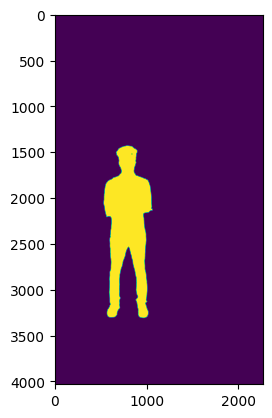

In [525]:
plt.imshow(comp_mask)

In [527]:
# b, m, x, y, w, h = a
b[y:y+h, x:x+w].shape, m.shape, h, w, cv2.boundingRect((comp_mask>0).astype('uint8'))

((968, 534, 3), (1881, 534), 1881, 534, (530, 1432, 534, 1881))

In [529]:
print(b.shape, y, y+h)
print(b.shape, x, x+w)

(2400, 1350, 3) 1432 3313
(2400, 1350, 3) 530 1064


In [475]:
harmonized = a.copy()
harmonized[:,:,0] = 0

mask_3 = np.stack([comp_mask>128]*3, axis=-1)
targeted_image = bg * (~mask_3) + harmonized * mask_3

plt.imshow(a)

AttributeError: 'tuple' object has no attribute 'copy'

In [170]:
blended[y:y+h, x:x+w][mask]

array([[125, 127, 121],
       [122, 124, 118],
       [120, 122, 116],
       ...,
       [150, 151, 149],
       [134, 135, 133],
       [144, 145, 143]], dtype=uint8)

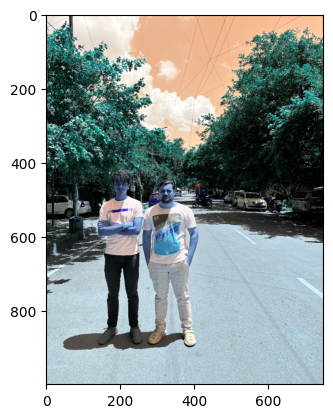

In [82]:
import cv2

img = cv2.imread('/Users/gauranshurathee/Desktop/shadow_positioning/test_data/png_raw_images_dataset/new_soft_shadow/BG_09_FG_01.png')
img.shape

(5712, 4284, 3)

In [107]:
mask_extractor = PersonSegmentationExtractor()
masks = mask_extractor.get_person_masks(fg)

Initialized Person Segmentation Extraction Models...

0: 384x640 1 person, 101.9ms
Speed: 5.0ms preprocess, 101.9ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 1024x1024 1 0, 2051.1ms
Speed: 12.7ms preprocess, 2051.1ms inference, 84.6ms postprocess per image at shape (1, 3, 1024, 1024)


In [116]:
mask.shape

(3376, 6000)

In [386]:
img=cv2.imread('/Users/gauranshurathee/Desktop/shadow_positioning/test_data/png_raw_images_dataset/hard_shadow/BG_20_FG_00.png')
img = constraint_image(img, 2400)
cv2.imwrite('bg.png', img)

True

In [122]:
mask = np.max(masks, axis=0)
alpha = np.dstack([fg, mask])
cv2.imwrite('fg.png', alpha)

True